# U.S. Treasury Notes and Bonds Yield Curve Forecasting using LSTM


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as pdr
import datetime
from matplotlib import pyplot as plt

## Import data

In [2]:
# Define the start and end date of the data range
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime.today()

# Pull data from the FRED api using pandas_datareader
tickers = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
name = ['1MO', '3MO', '6MO', '1YR', '2YR', '3YR', '5YR', '7YR', '10YR', '20YR', '30YR']
df = pdr.get_data_fred(tickers, start, end).dropna()      # drop missing values
df = df.rename(columns={tickers[i]:name[i] for i in range(len(tickers))})

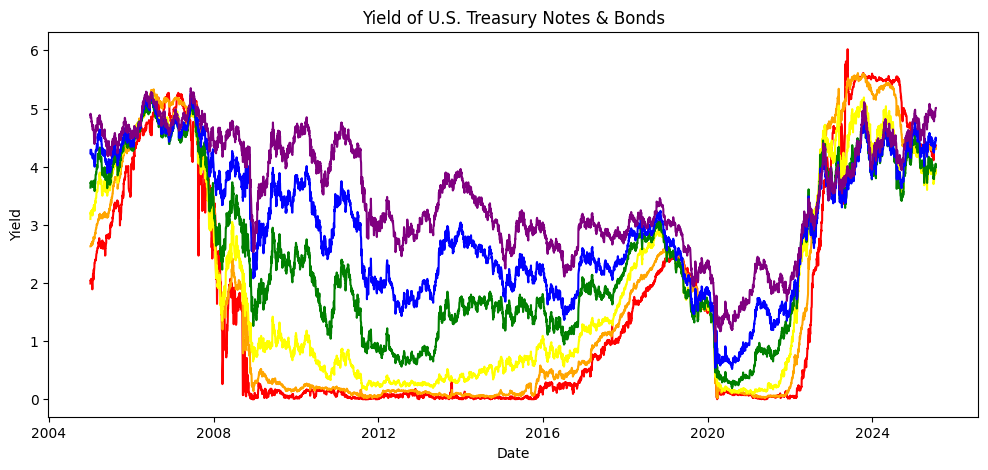

In [3]:
# Plot yields through time
plt.figure(figsize = (12,5))
plt.plot(df['1MO'], color='red')
plt.plot(df['6MO'], color='orange')
plt.plot(df['2YR'], color='yellow')
plt.plot(df['5YR'], color='green')
plt.plot(df['10YR'], color='blue')
plt.plot(df['30YR'], color='purple')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Yield of U.S. Treasury Notes & Bonds')
plt.show()

In [4]:
# Split into training 80%/ validation 10% / testing 10% 
n_train_end = int(len(df) * 0.8)
n_valid_end = int(len(df) * 0.9)
df_train = df.iloc[:n_train_end]
df_valid = df.iloc[n_train_end:n_valid_end]
df_test = df.iloc[n_valid_end:]

## PCA

In [5]:
# Do PCA on the training set
# Center the train data before PCA
yield_mean = df_train.mean()
df_train_c = df_train - yield_mean
df_valid_c = df_valid - yield_mean

# Get the first three principal components
pca = PCA(n_components=3)
pca.fit(df_train_c)
loadings = pca.components_

# Represent the original training data and validation data with a basis of the first three loadings
scores_train = df_train_c.to_numpy() @ loadings.T
scores_valid = df_valid_c.to_numpy() @ loadings.T


## LSTM

### Data preprocessing

In [6]:
# Preprocess score data
scaler = StandardScaler()
scaler.fit(scores_train)
scaled_scores_train = scaler.transform(scores_train)
scaled_scores_valid = scaler.transform(scores_valid)

# Prepare LSTM input
def create_LSTM_input(data, lag):
    X, Y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        Y.append(data[i+lag])
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    Y_tensor = torch.tensor(np.array(Y), dtype=torch.float32)
    return X_tensor, Y_tensor

lag = 10
Xtr, Ytr = create_LSTM_input(scaled_scores_train, lag)
Xv, Yv = create_LSTM_input(scaled_scores_valid, lag)

# Wrap the data in torch TensorDataset, DataLoader
dataset = TensorDataset(Xtr, Ytr)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

### Construct LSTM model

In [7]:
# Construct LSTM model

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            num_layers,
                            dropout = dropout,
                            batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)               # out: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]                 # use last output for forecasting
        out = self.linear(out)              # project to output dimension
        return out

model = LSTM(input_dim=3, hidden_dim=128, output_dim=3)

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 5

### Train

In [14]:
# Train LSTM model
model.train()
for epoch in range(epochs):
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_func(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.0115
Epoch 1: loss = 0.0138
Epoch 2: loss = 0.0087
Epoch 3: loss = 0.0106
Epoch 4: loss = 0.0063


In [15]:
# Validate model to prevent overfitting
model.eval()
train_loss = loss_func(model(Xtr), Ytr)
val_loss = loss_func(model(Xv), Yv)
print(f'Train loss      : {train_loss}')
print(f'Validation loss : {val_loss}')

Train loss      : 0.009215092286467552
Validation loss : 0.07293173670768738


In [16]:
# Evaluate model using the test data

# Forecast
model.eval()
scores_fore = []

with torch.no_grad():
    x = torch.cat((Xv[-1:], torch.unsqueeze(Yv[-1:],0)), dim=1)[:,1:,:]
    for _ in range(len(df_test)):
        y = model(x)
        scaled_score = scaler.inverse_transform(y.numpy())
        scores_fore.append(scaled_score[0])
        x = torch.cat((x, torch.unsqueeze(y,0)), dim=1)[:,1:,:]
        
# Transfrom forecasted scores into yields
yield_fore = pd.DataFrame(pca.inverse_transform(np.array(scores_fore)), columns=df.columns, index=df_test.index) + yield_mean
yield_fore

,1MO,3MO,6MO,1YR,2YR,3YR,5YR,7YR,10YR,20YR,30YR
DATE,,,,,,,,,,,
2023-06-27,5.153206,5.177954,5.219468,5.015752,4.559715,4.250793,3.910461,3.772441,3.790028,3.955236,3.942698
2023-06-28,5.133794,5.161252,5.206395,5.007759,4.560986,4.257771,3.922278,3.785170,3.800504,3.963289,3.948696
2023-06-29,5.123689,5.153248,5.201327,5.006485,4.567166,4.269105,3.939331,3.804291,3.819446,3.982076,3.965110
2023-06-30,5.115413,5.146697,5.197267,5.005614,4.572912,4.279748,3.956142,3.823815,3.839845,4.003485,3.984294
2023-07-03,5.108710,5.141463,5.194193,5.005275,4.578417,4.289732,3.972092,3.842565,3.859852,4.024915,4.003670
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-11,5.149615,5.242385,5.382521,5.287775,5.062649,4.930089,4.819247,4.779083,4.834575,5.042499,4.917607
2025-07-14,5.149614,5.242384,5.382521,5.287777,5.062653,4.930094,4.819254,4.779091,4.834582,5.042505,4.917612
2025-07-15,5.149613,5.242384,5.382523,5.287779,5.062658,4.930101,4.819262,4.779099,4.834590,5.042512,4.917618


In [17]:
# Calculate the MSE between the predicted yield and the actual yield
MSE = np.mean(np.sum((yield_fore.to_numpy() - df_test.to_numpy())**2, axis=1))
print(f'Mean Square Error : {MSE}')

Mean Square Error : 4.334564015786172


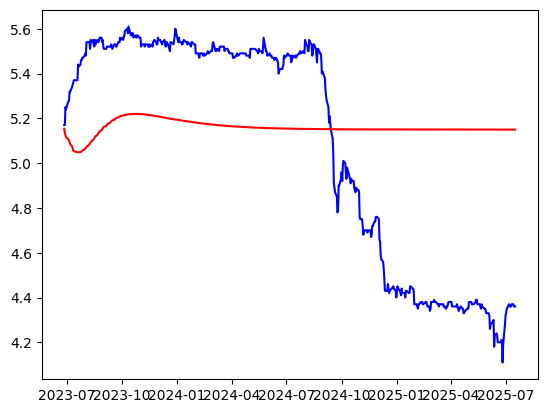

In [18]:
# Plot the froecasted and actual yield curve
plt.plot(df_test['1MO'], color='blue')
plt.plot(yield_fore['1MO'], color='red')
plt.show()